In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from utils import standardize

Why logistic regression?
    - Logistic regression is used for binary classification. This suits our project as we are classifying whether a tumour is malignant (M) or benign (B).

How will we evaluate the model?
   - Bias (how accurate the model is)
   - Variance (how spread out the predictions are from the mean)

(This shows us if our model is overfitting / underfitting)

Since it's a classification algorithm, we evaluate it with:
- Accuracy
- Precision
- Recall

Confusion matrix to see the distribution of TP, FP, TN, FN

IMPORTANT TODO:
- Cost of FN is much higher than TP, FP, TN
- IS MY MODEL OVERFITTING / UNDERFITTING? <- how can we check? (bias / variance tradeoff)
- Make heatmap of confusion matrix

Chi-squared tests to see which variables are useless?

https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial

In [126]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
labels = df['B/M']
features = df[['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension']]

In [127]:
# Standardize features
features = standardize(features)

/home/nicky/Documents/CS/ai/ai_coursework/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns if columns else df.select_dtypes(['float64', 'int64']).columns.values] = ColumnTransformer([


Distribution of B / M, we will use this result when comparing our model to a dummy model later

In [128]:
labels.value_counts()

B    357
M    212
Name: B/M, dtype: int64

In [129]:
# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [130]:
# Fit model to training data
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
# Accuracy
accuracy = model.score(x_test, y_test)

In [131]:
y_pred

array(['B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B',
       'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M',
       'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'M', 'B',
       'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B',
       'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'M',
       'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'M',
       'M', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B',
       'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B'], dtype=object)

Investigate classifications by our model:

In [132]:
c = confusion_matrix(y_test, y_pred)

print(f'True negatives: {c[0][0]}')
print(f'False negatives: {c[1][0]}')
print(f'True positives: {c[1][1]}')
print(f'False positives: {c[0][1]}')

True negatives: 74
False negatives: 4
True positives: 31
False positives: 5


In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.95      0.94      0.94        79
           M       0.86      0.89      0.87        35

    accuracy                           0.92       114
   macro avg       0.90      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



In [134]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label="M")}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label="M", zero_division=0)}')

Accuracy: 0.9210526315789473
Recall: 0.8857142857142857
Precision: 0.8611111111111112


Dummy classifier:
Our dummy model will classify data with the label that occurs most often. Does our model beat the dummy model?

In [135]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model


# 3. Hyperparameter Tuning

# 3.1 ROC Curve
Tuning the threshold p-value and seeing how this affects our classifications.

ROC Curves shows us the True Positive rate (TP / (TP + FN)) against the False Positive Rate (FP / (FP + TN)) with different thresholds.

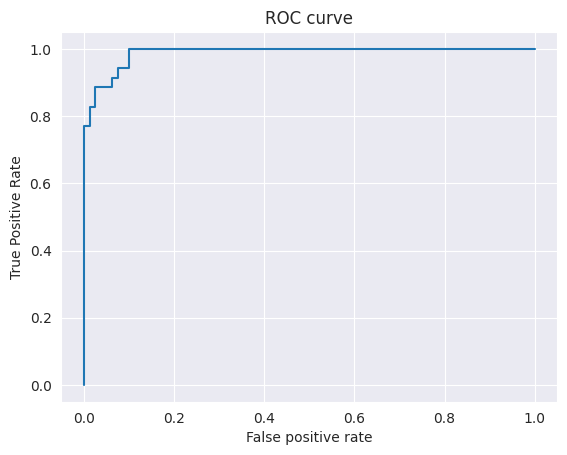

In [136]:
# First col is the p that a sample is class B, second col is p that sample is class M
y_pred_prob = model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label = 'M')

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
# todo: add legend?
plt.show()

We want to find the threshold which finds the balance between the TPR and the FPR.

Since our model is being used to classify tumorous cells, it is important to maximise the TPR.

NOTE: after changing the threshold, see if you are overfitting.

In [137]:
for metric in list(zip(tpr, fpr, thresholds))[1::]:
    tpr_, fpr_, threshold =  metric[0], metric[1], metric[2]
    print(f'''
    TPR: {tpr_}
    FPR: {fpr_}
    threshold: {threshold}''')


    TPR: 0.02857142857142857
    FPR: 0.0
    threshold: 0.9999999995363726

    TPR: 0.7714285714285715
    FPR: 0.0
    threshold: 0.9156651554362577

    TPR: 0.7714285714285715
    FPR: 0.012658227848101266
    threshold: 0.8627604773165092

    TPR: 0.8285714285714286
    FPR: 0.012658227848101266
    threshold: 0.729425662535056

    TPR: 0.8285714285714286
    FPR: 0.02531645569620253
    threshold: 0.6549785754919034

    TPR: 0.8857142857142857
    FPR: 0.02531645569620253
    threshold: 0.5668617594271542

    TPR: 0.8857142857142857
    FPR: 0.06329113924050633
    threshold: 0.5288858213605262

    TPR: 0.9142857142857143
    FPR: 0.06329113924050633
    threshold: 0.3893921896632727

    TPR: 0.9142857142857143
    FPR: 0.0759493670886076
    threshold: 0.3640917179319775

    TPR: 0.9428571428571428
    FPR: 0.0759493670886076
    threshold: 0.3453205490815116

    TPR: 0.9428571428571428
    FPR: 0.10126582278481013
    threshold: 0.2748898375032912

    TPR: 1.0
    FP

# Selecting a threshold

A TPR of 1 means that there are no FNs (M cells classified as B). But as TPR increases, so does FPR. We must find the balance of maximising TPR while minimizing FPR as FPs have a cost:
(e.g. patients having to go through intense chemotherapy as their benign tumour is treated as malignant)

I think a reasonable balance is
**TPR: 0.933...**
**FPR: 0.0724...**
**Threshold = 0.44972366367104066**
*(which is slightly lower than the default 0.5)*

# AUC
AUC is the area under the ROC graph. **We can use AUC to compare two classification models**.

In [139]:
roc_auc_score(y_true=y_test, y_score=y_pred_prob[:, 1])

0.9880650994575045